# 1. Introduction

MOCHIS is a software that allows the user to perform flexible non-parametric tests of differential gene expression. Such tests include the popular Mann-Whitney (Wilcoxon rank sum) test, which was recently promoted by Li et al. (2022) as an approach to perform differential analysis on RNA-seq data without incurring an inflated false positive rate.
In this markdown document, we explore how MOCHIS can detect multiple kinds of differential gene expression signatures, including mean shifts or dispersion shifts. Dispersion shifts have recently been shown to characterize age-related changes in gene expression (see Schaum et al., 2020 and Yamamoto and Chung et al., 2022+). In particular, we:
- perform multiple kinds of two-sample tests on all single-cell tissue data provided in Tabula muris senis 
- report and compare findings across the different kinds of tests
For Section 3 (Analysis), all our analyses are followed by a summary of key findings, to help the reader quickly grasp the main points.


In [1]:
# Setup

import scanpy
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from main_draft0 import *
import scipy
import statistics
import csv
import os
import seaborn as sns
from matplotlib_venn import venn2
import math

np.random.seed(2022)

# 2. Data
Publicly available _mus musculus_ (house mice) single-cell RNA-seq data from the Chan-Zuckerberg Initiative (also known as _Tabula Muris Senis_) is used. We download senescence datasets from [here](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb). These datasets are made up of single cell gene transcript levels measured using Smart-Seq2, across $22$ distinct mice tissues. For each tissue, the cells originate from mice that are either 3 months, 18 months or 24 months old (with the exception of the mammary gland tissue, which has 3 months, 18 months and 21 months). There are also other cell labels like tissue location (identified with guidance from biologists) and mice sex.

Below, we perform the Mann-Whitney test to identify genes that are differentially expressed, also known as differentially expressed genes (DEGs), across age groups. We compare each pair of age group, so that for each gene ${3\choose 2}=3$ tests are performed. 

We restrict our analysis to those regions where the zero counts are the fewest, using an $80\%$ cut-off. This avoids running tests on genes that have pronounced zero inflation, which hinders the detection of differential expression. 

We additionally compute a "ratio of variances" index, which heuristic measures of the difference in dispersion across the pair of age groups. The larger the ratio of variances, the more differentially dispersed the gene expression between the pair of age groups.

In [2]:
%%capture
# Perform analysis for each tissue
# There are 22 tissues
all_tissues = sorted(["bone-marrow",
              "brain-myeloid",
              "heart",
              "large-intestine",
              "lung",
              "skin-of-body",
              "thymus",
              "limb-muscle",
              "spleen",
              "subcutaneous-adipose-tissue",
              "tongue",
              "gonadal-fat-pad",
              "pancreas",
              "mammary-gland",
              "trachea",
              "mesenteric-fat-pad",
              "liver",
              "bladder-lumen",
              "brown-adipose-tissue",
              "diaphragm",
              "kidney",
              "aorta"])


for tissue in all_tissues:
    #os.mkdir(os.path.join("tissues/", tissue))
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].index)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
    #print(smartseq2_raw_counts.shape)  # 14517 mice cells x 21069 regions
    
    # Get cutoff and restrict to only those genes
    cutoff = round(0.8*smartseq2_raw_counts.shape[0])
    
    cell_count_sums_by_region = np.count_nonzero(smartseq2_raw_counts, axis=0)

    highly_expressed_genes_indices = [i for i,v in enumerate(cell_count_sums_by_region) if v > cutoff] # row_ids
  
    smartseq2_high_exp_sparse_mat = []
    for i in highly_expressed_genes_indices:
        smartseq2_high_exp_sparse_mat.append(smartseq2_raw_counts[:, i])
    
    print("Found ", len(highly_expressed_genes_indices), " genes out of ", smartseq2_raw_counts.shape[0], " genes meeting the cutoff threshold...")

    highly_expressed_transcripts = [transcripts[i] for i in highly_expressed_genes_indices]

    # Grab age labels
    #smartseq2_df = anndata.AnnData(np.transpose(smartseq2_high_exp_sparse_mat), pd.DataFrame(ages, columns=['ages']), pd.DataFrame(highly_expressed_transcripts, columns=['highly_expressed_transcripts']) )
    smartseq2_df = pd.DataFrame(np.append(np.transpose(smartseq2_high_exp_sparse_mat),[[i] for i in tissue_smartseq2_data.obs['age'].values], axis=1), columns = highly_expressed_transcripts + ['ages'])

    # Run Mann-Whitney test for genes
    gene_names = smartseq2_df.columns.values[:-1]
    results_df = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY_3_18', 'MANN_WHITNEY_18_24', 'MANN_WHITNEY_24_3', 'VAR_3_18', 'VAR_18_24', 'VAR_24_3'])
    
    print("How many cells of each age group?")
    print(smartseq2_df['ages'].value_counts())
    
    
    # Run test for each gene
    for i in range(len(gene_names)):
        to_run_test = smartseq2_df[[gene_names[i], 'ages']]
        
        if tissue == "mammary-gland":
            print("Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...")
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "21m", gene_names[i]].values
        else:
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "24m", gene_names[i]].values
            
        age_3m = [float(i) for i in age_3m]
        age_18m = [float(i) for i in age_18m]
        age_24m = [float(i) for i in age_24m]
        
        wrs_test_3_18 = scipy.stats.mannwhitneyu(x=age_3m, y=age_18m, alternative='two-sided')
        wrs_test_18_24 = scipy.stats.mannwhitneyu(x=age_18m, y=age_24m, alternative='two-sided')
        wrs_test_24_3 = scipy.stats.mannwhitneyu(x=age_3m, y=age_24m, alternative='two-sided')
        
        var_3_18 = max(statistics.variance(age_3m)/statistics.variance(age_18m), statistics.variance(age_18m)/statistics.variance(age_3m))
        var_18_24 = max(statistics.variance(age_18m)/statistics.variance(age_24m),statistics.variance(age_24m)/statistics.variance(age_18m))
        var_24_3 = max(statistics.variance(age_24m)/statistics.variance(age_3m),statistics.variance(age_3m)/statistics.variance(age_24m))
        
        results_df = results_df.append({
            'TRANSCRIPT': gene_names[i],
            'MANN_WHITNEY_3_18': wrs_test_3_18.pvalue,
            'MANN_WHITNEY_18_24': wrs_test_18_24.pvalue,
            'MANN_WHITNEY_24_3': wrs_test_24_3.pvalue,
            'VAR_3_18': var_3_18,
            'VAR_18_24': var_18_24,
            'VAR_24_3': var_24_3
        }, ignore_index=True)
        
        
        
        
    print("Saving results for ", tissue)
    results_df.to_csv("tissues/"+tissue+"/p_val_table.csv")



## 2.1 Mann-Whitney DEGs

Given we have the tables of $p$-values and ratios of variances from the previous step, we now select genes whose $p$-values, after a Benjamini-Hochberg adjustment procedure, lie below or equal to a $0.05$ significance level. These are Mann-Whitney significant genes that would be flagged as potentially carrying biological signal in a typical differential expression analysis procedure.

In [3]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [4]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'MANN_WHITNEY', 'VARIANCE_RATIO', 'TISSUE'])


for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    tissue_mann_whitney_df = pd.read_csv("tissues/"+tissue+"/p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MANN_WHITNEY_3_18", "VAR_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MANN_WHITNEY_3_18":"MANN_WHITNEY", "VAR_3_18":"VARIANCE_RATIO"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MANN_WHITNEY_18_24", "VAR_18_24"]]
    selected_genes_18_24 = selected_genes_18_24.rename(columns={"MANN_WHITNEY_18_24":"MANN_WHITNEY", "VAR_18_24":"VARIANCE_RATIO"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MANN_WHITNEY_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MANN_WHITNEY_24_3", "VAR_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MANN_WHITNEY_24_3":"MANN_WHITNEY", "VAR_24_3":"VARIANCE_RATIO"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])
    
tissue_transcript_3_18.to_csv("tissues/mw_sig_3m_18m.csv")
tissue_transcript_18_24.to_csv("tissues/mw_sig_18m_24m.csv")
tissue_transcript_24_3.to_csv("tissues/mw_sig_24m_3m.csv")


Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

Let us visualize the raw $p$-values and variance ratios of the Mann-Whitney DEGs fished out from the above procedure. 

In [5]:
df_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
df_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
df_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")


df_3_18["PAIR"] = ["3m vs 18m" for i in range(df_3_18.shape[0])]
df_18_24["PAIR"] = ["18m vs 24m" for i in range(df_18_24.shape[0])]
df_24_3["PAIR"] = ["3m vs 24m" for i in range(df_24_3.shape[0])]


<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

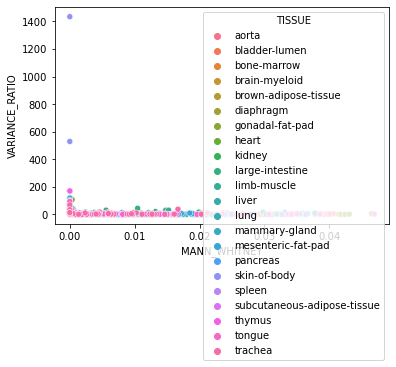

In [6]:
sns.scatterplot(data=df_18_24, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

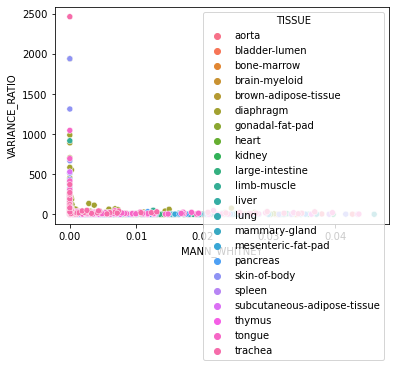

In [7]:
sns.scatterplot(data=df_3_18, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MANN_WHITNEY', ylabel='VARIANCE_RATIO'>

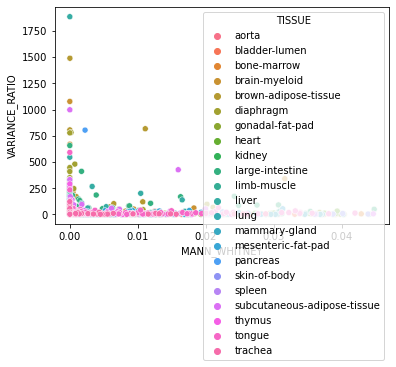

In [8]:
sns.scatterplot(data=df_24_3, x='MANN_WHITNEY', y='VARIANCE_RATIO', hue='TISSUE')

Next we look at the distribution, across tissues, of Mann-Whitney significant genes.

In [9]:
print("No. MW significant genes for 3m vs 18m: ", df_3_18.shape[0])
print("No. MW significant genes for 18m vs 24m: ", df_18_24.shape[0])
print("No. MW significant genes for 24m vs 3m: ", df_24_3.shape[0])

No. MW significant genes for 3m vs 18m:  5571
No. MW significant genes for 18m vs 24m:  5305
No. MW significant genes for 24m vs 3m:  5634


<AxesSubplot:ylabel='None'>

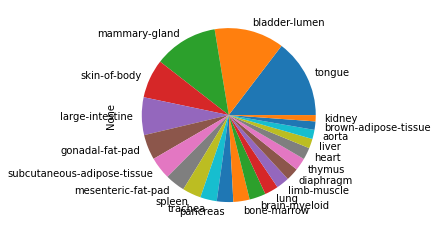

In [10]:
df_3_18.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

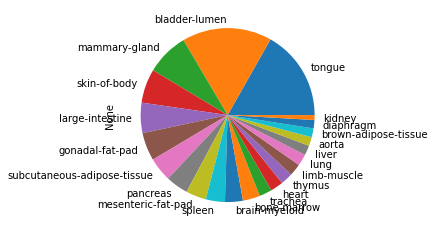

In [11]:
df_18_24.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

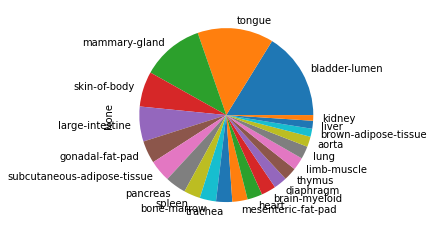

In [12]:
df_24_3.value_counts("TISSUE").plot(kind="pie")

## 2.2 MOCHIS

We now repeat the DEG identification procedure above, now using our flexible non-parametric testing software MOCHIS. We run MOCHIS with test statistic $||S_{n,k}||_{p,\boldsymbol{w}}^p$. We choose the following parametrization:

- $p=1$
- $\boldsymbol{w}=\left((\frac{j}{k} - \frac{1}{2})^2:j = 1,\ldots,k\right)$

This parametrization optimizes detection of dispersion shifts between two samples. 

**Step 1.** Compute $p$-values.

When computing the $p$-values, we apply a tie-breaking routine (adding noise ranging from $-0.25$ to $0.25$, which is less than the minimum spacing width of integer counts). To ensure that this routine does not overly contaminate the data, we also compute Mann-Whitney $p$-values and check that the Mann-Whitney DEGs identified after applying the tie-breaking routine are not markedly different from the original DEGs identified in Section 2.1. We report this latter comparison between post-contamination and original DEGs in Section 2.3. (Heads up: We find little difference.)  

In [13]:
%%capture
for tissue in all_tissues:
    
    #os.mkdir(os.path.join("tissues/", tissue))

    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].index)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
    print(smartseq2_raw_counts.shape)  # 14517 mice cells x 21069 regions
    
    # Get cutoff and restrict to only those genes
    cutoff = round(0.8*smartseq2_raw_counts.shape[0])
    
    cell_count_sums_by_region = np.count_nonzero(smartseq2_raw_counts, axis=0)

    highly_expressed_genes_indices = [i for i,v in enumerate(cell_count_sums_by_region) if v > cutoff] # row_ids
  
    smartseq2_high_exp_sparse_mat = []
    for i in highly_expressed_genes_indices:
        smartseq2_high_exp_sparse_mat.append(smartseq2_raw_counts[:, i])
    
    print("Found ", len(highly_expressed_genes_indices), " genes out of ", smartseq2_raw_counts.shape[0], " genes meeting the cutoff threshold...")

    highly_expressed_transcripts = [transcripts[i] for i in highly_expressed_genes_indices]

    # Grab age labels
    #smartseq2_df = anndata.AnnData(np.transpose(smartseq2_high_exp_sparse_mat), pd.DataFrame(ages, columns=['ages']), pd.DataFrame(highly_expressed_transcripts, columns=['highly_expressed_transcripts']) )
    smartseq2_df = pd.DataFrame(np.append(np.transpose(smartseq2_high_exp_sparse_mat),[[i] for i in tissue_smartseq2_data.obs['age'].values], axis=1), columns = highly_expressed_transcripts + ['ages'])
    
    
    # Run Mann-Whitney test for genes
    gene_names = smartseq2_df.columns.values[:-1]
    
    
    results_df = pd.DataFrame(columns=['TRANSCRIPT', 
                                       'MOCHIS_3_18', 
                                       'MW_3_18', 
                                       'MOCHIS_18_24', 
                                       'MW_18_24', 
                                       'MOCHIS_24_3', 
                                       'MW_24_3', 
                                       'VAR_3_18', 
                                       'INV_3_18',
                                       'VAR_18_24',
                                       'INV_18_24',
                                       'VAR_24_3',
                                       'INV_24_3'])
    print("How many cells of each age group?")
    print(smartseq2_df['ages'].value_counts())
    
    # Run test for each gene
    for i in range(len(gene_names)):
        to_run_test = smartseq2_df[[gene_names[i], 'ages']]
        
        if tissue == "mammary-gland":
            print("Reminder that mammary-gland has 3m, 18m and 21m age groups, so interpret 24m as 21m...")
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "21m", gene_names[i]].values
        else:
            age_3m = to_run_test.loc[to_run_test["ages"] == "3m", gene_names[i]].values
            age_18m = to_run_test.loc[to_run_test["ages"] == "18m", gene_names[i]].values
            age_24m = to_run_test.loc[to_run_test["ages"] == "24m", gene_names[i]].values
            
        age_3m = [float(i) for i in age_3m]
        age_18m = [float(i) for i in age_18m]
        age_24m = [float(i) for i in age_24m]
        
        
        # Add noise to break ties
        
        noisy_age_3m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_3m])
        noisy_age_18m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_18m])
        noisy_age_24m = np.sort([value + np.random.uniform(-1/4, 1/4) for value in age_24m])
        
        
        wrs_test_3_18 = scipy.stats.mannwhitneyu(x=noisy_age_3m, y=noisy_age_18m, use_continuity=False,  method='asymptotic')
        wrs_test_18_24 = scipy.stats.mannwhitneyu(x=noisy_age_18m, y=noisy_age_24m, use_continuity=False,  method='asymptotic')
        wrs_test_24_3 = scipy.stats.mannwhitneyu(x=noisy_age_3m, y=noisy_age_24m, use_continuity=False,  method='asymptotic')
        

        
        if len(noisy_age_3m) > len(noisy_age_18m):
            #print("3 > 18")
            
            k = len(age_18m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_3_18 = mochis_py(x = noisy_age_18m,
                                         p = 1,
                                         wList = mochis_weights,
                                         alternative = "two.sided",
                                         approx = "chebyshev",
                                         n_mom = 100,
                                         y = noisy_age_3m)
            
        else:
            #print(" 18 > 3")
            
            k = len(age_3m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_3_18 = mochis_py(x = noisy_age_3m,
                                         p = 1,
                                         wList = mochis_weights,
                                         alternative = "two.sided",
                                         approx = "chebyshev",
                                         n_mom = 100,
                                         y = noisy_age_18m)


            
        if len(noisy_age_18m) > len(noisy_age_24m):
            #print("18 > 24")
            
            k = len(noisy_age_24m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_18_24 = mochis_py(x = noisy_age_24m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_18m)
            
        else:
            #print("24 > 18")
        
            k = len(noisy_age_18m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_18_24 = mochis_py(x = noisy_age_18m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_24m)
            
            
        if len(noisy_age_3m) > len(noisy_age_24m):
            #print("3 > 24")
            
            k = len(noisy_age_24m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_24_3 = mochis_py(x = noisy_age_24m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_3m)
            
        else:
            #print(" 24 > 3")
            
            k = len(noisy_age_3m) + 1
            mochis_weights = [(i/k-0.5)**2 for i in range(1,k+1)]
            mochis_test_24_3 = mochis_py(x = noisy_age_3m,
                                        p = 1,
                                        wList = mochis_weights,
                                        alternative = "two.sided",
                                        approx = "chebyshev",
                                        n_mom = 100,
                                        y = noisy_age_24m)
            
        
        
        var_3_18 = max(statistics.variance(age_3m)/statistics.variance(age_18m), statistics.variance(age_18m)/statistics.variance(age_3m))
        var_18_24 = max(statistics.variance(age_18m)/statistics.variance(age_24m),statistics.variance(age_24m)/statistics.variance(age_18m))
        var_24_3 = max(statistics.variance(age_24m)/statistics.variance(age_3m),statistics.variance(age_3m)/statistics.variance(age_24m))
        
        invert_3_18 = False
        invert_18_24 = False
        invert_24_3 = False
        if var_3_18 == statistics.variance(age_3m)/statistics.variance(age_18m):
            invert_3_18 = True
        if var_18_24 == statistics.variance(age_18m)/statistics.variance(age_24m):
            invert_18_24 = True
        if var_24_3 == statistics.variance(age_3m)/statistics.variance(age_24m):
            invert_24_3 = True
        
        results_df = pd.concat([results_df, pd.DataFrame([{
            "TRANSCRIPT": gene_names[i],
            "MOCHIS_3_18": mochis_test_3_18,
            "MW_3_18": wrs_test_3_18.pvalue,
            "MOCHIS_18_24": mochis_test_18_24,
            "MW_18_24": wrs_test_18_24.pvalue,
            "MOCHIS_24_3": mochis_test_24_3,
            "MW_24_3": wrs_test_24_3.pvalue,
            "VAR_3_18": var_3_18,
            "INV_3_18": invert_3_18,
            "VAR_18_24": var_18_24,
            "INV_18_24": invert_18_24,
            "VAR_24_3": var_24_3,
            "INV_24_3": invert_24_3
        }])])
    
    print("Saving results for ", tissue)
    results_df.to_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    

In [14]:
results_df

,TRANSCRIPT,MOCHIS_3_18,MW_3_18,MOCHIS_18_24,MW_18_24,MOCHIS_24_3,MW_24_3,VAR_3_18,INV_3_18,VAR_18_24,INV_18_24,VAR_24_3,INV_24_3
0,ENSMUSG00000032231,9.752003e-43,1.451935e-01,2.950021e-01,1.198098e-01,6.831664e-40,3.398592e-05,17.085418,False,1.497434,True,11.409794,False
0,ENSMUSG00000030057,1.062117e-60,9.997725e-01,1.007576e-02,8.085033e-03,4.367818e-55,8.077978e-09,23.321075,False,2.483312,True,9.391119,False
0,ENSMUSG00000090862,3.581052e-44,4.380674e-14,7.863551e-04,7.343121e-01,1.011570e-38,5.114951e-15,24.470407,False,2.396878,True,10.209285,False
0,ENSMUSG00000022982,1.767715e-57,1.068400e-03,3.304904e-16,1.131972e-04,2.384471e-24,4.834679e-03,6.468682,False,2.412707,True,2.681089,False
0,ENSMUSG00000041841,5.304230e-34,1.957629e-05,1.354376e-03,2.027297e-23,1.663534e-05,6.314370e-28,21.185682,False,12.094871,True,1.751625,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ENSMUSG00000028410,1.495667e-51,2.803420e-01,9.591054e-02,2.537637e-01,2.629838e-69,1.338141e-03,18.025303,False,1.897966,True,9.497168,False
0,ENSMUSG00000023010,1.511680e-64,4.598110e-01,6.458309e-10,7.323468e-02,6.021564e-46,2.314095e-03,31.083139,False,6.856617,True,4.533305,False
0,ENSMUSG00000092341,2.145714e-31,7.465742e-39,5.027337e-19,1.667774e-02,5.120951e-14,1.674369e-47,272.950277,False,38.300656,True,7.126517,False
0,ENSMUSG00000060636,5.430763e-44,1.227435e-05,5.456979e-07,2.240672e-14,1.506204e-15,1.016657e-11,30.299156,False,13.981119,True,2.167148,False


Step 2. Identify MOCHIS significant genes (with FDR control at 0.05)

In [15]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'MOCHIS', 'VARIANCE_RATIO', 'TISSUE'])


for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    tissue_mochis_df = pd.read_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MOCHIS_3_18", "VAR_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MOCHIS_3_18":"MOCHIS", "VAR_3_18":"VARIANCE_RATIO"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MOCHIS_18_24", "VAR_18_24"]]
    selected_genes_18_24 = selected_genes_18_24.rename(columns={"MOCHIS_18_24":"MOCHIS", "VAR_18_24":"VARIANCE_RATIO"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mochis_df[p_adjust_bh(tissue_mochis_df['MOCHIS_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MOCHIS_24_3", "VAR_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MOCHIS_24_3":"MOCHIS", "VAR_24_3":"VARIANCE_RATIO"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])
    
tissue_transcript_3_18.to_csv("tissues/mochis_sig_3m_18m.csv")
tissue_transcript_18_24.to_csv("tissues/mochis_sig_18m_24m.csv")
tissue_transcript_24_3.to_csv("tissues/mochis_sig_24m_3m.csv")


Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

Step 3. Visualization.

First, let us visualize the raw p-values and variance ratios of the MOCHIS DEGs fished out from the above procedure.

In [16]:
df_3_18 = pd.read_csv("tissues/mochis_sig_3m_18m.csv")
df_18_24 = pd.read_csv("tissues/mochis_sig_18m_24m.csv")
df_24_3 = pd.read_csv("tissues/mochis_sig_24m_3m.csv")


df_3_18["PAIR"] = ["3m vs 18m" for i in range(df_3_18.shape[0])]
df_18_24["PAIR"] = ["18m vs 24m" for i in range(df_18_24.shape[0])]
df_24_3["PAIR"] = ["3m vs 24m" for i in range(df_24_3.shape[0])]

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

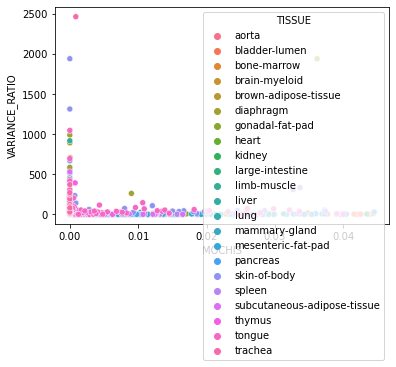

In [17]:
sns.scatterplot(data=df_3_18, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

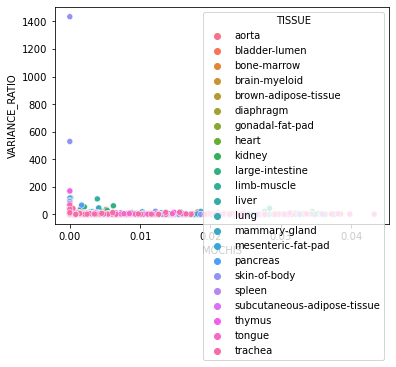

In [18]:
sns.scatterplot(data=df_18_24, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

<AxesSubplot:xlabel='MOCHIS', ylabel='VARIANCE_RATIO'>

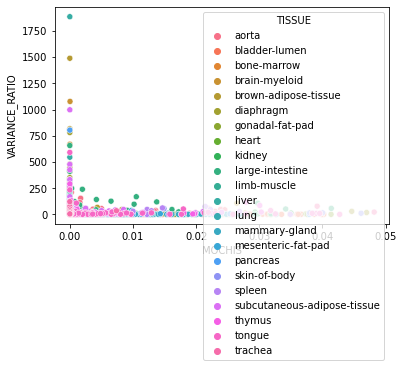

In [19]:
sns.scatterplot(data=df_24_3, x='MOCHIS', y='VARIANCE_RATIO', hue='TISSUE')

Next we look at the distribution, across tissues, of MOCHIS significant genes.

In [20]:
print("No. MOCHIS significant genes for 3m vs 18m: ", df_3_18.shape[0])
print("No. MOCHIS significant genes for 18m vs 24m: ", df_18_24.shape[0])
print("No. MOCHIS significant genes for 24m vs 3m: ", df_24_3.shape[0])


No. MOCHIS significant genes for 3m vs 18m:  5731
No. MOCHIS significant genes for 18m vs 24m:  4787
No. MOCHIS significant genes for 24m vs 3m:  5486


<AxesSubplot:ylabel='None'>

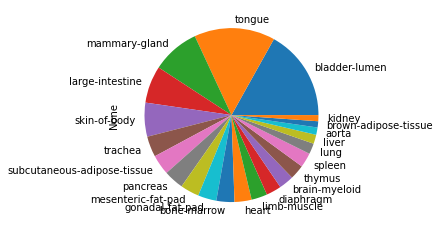

In [21]:
df_3_18.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

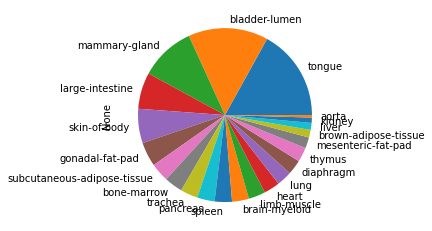

In [22]:
df_18_24.value_counts("TISSUE").plot(kind="pie")

<AxesSubplot:ylabel='None'>

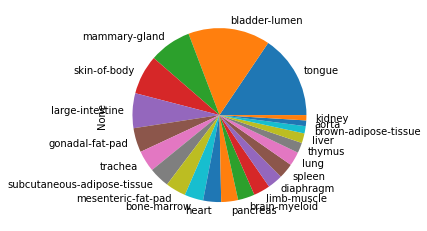

In [23]:
df_24_3.value_counts("TISSUE").plot(kind="pie")

## 2.3 Impact of Tie Breaking on Mann-Whitney DEGs

In Section 2.2, we raised the issue of tie breaking potentially affecting the significance of Mann-Whitney DEGs. Here, we check for difference between post-contaminated Mann-Whitney DEGs (this Section) and original DEGs (Section 2.1).

In [24]:
tissue_transcript_3_18 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])
tissue_transcript_18_24 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])
tissue_transcript_24_3 = pd.DataFrame(columns=['TRANSCRIPT', 'NEW_MANN_WHITNEY', 'TISSUE'])

for tissue in all_tissues:
    print("Reading in summary of p-values and ratios of variances for ", tissue)
    
    tissue_mann_whitney_df = pd.read_csv("tissues/"+tissue+"/mochis_p_val_table.csv")
    
    # Pick genes where one of the three pairs (3m, 18m, 24m) has significant p-value at FDR 0.05 control
    selected_genes_3_18 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_3_18']) <= 0.05]
    selected_genes_3_18 = selected_genes_3_18[["TRANSCRIPT", "MW_3_18"]]
    selected_genes_3_18= selected_genes_3_18.rename(columns={"MW_3_18":"NEW_MANN_WHITNEY"})
    selected_genes_3_18["TISSUE"] = [tissue for i in range(selected_genes_3_18.shape[0])]
    tissue_transcript_3_18 = pd.concat([tissue_transcript_3_18, selected_genes_3_18])
    
    selected_genes_18_24 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_18_24']) <= 0.05]
    selected_genes_18_24 = selected_genes_18_24[["TRANSCRIPT", "MW_18_24"]]
    selected_genes_18_24= selected_genes_18_24.rename(columns={"MW_18_24":"NEW_MANN_WHITNEY"})
    selected_genes_18_24["TISSUE"] = [tissue for i in range(selected_genes_18_24.shape[0])]
    tissue_transcript_18_24 = pd.concat([tissue_transcript_18_24, selected_genes_18_24])
    
    selected_genes_24_3 = tissue_mann_whitney_df[p_adjust_bh(tissue_mann_whitney_df['MW_24_3']) <= 0.05]
    selected_genes_24_3 = selected_genes_24_3[["TRANSCRIPT", "MW_24_3"]]
    selected_genes_24_3 = selected_genes_24_3.rename(columns={"MW_24_3":"NEW_MANN_WHITNEY"})
    selected_genes_24_3["TISSUE"] = [tissue for i in range(selected_genes_24_3.shape[0])]
    tissue_transcript_24_3 = pd.concat([tissue_transcript_24_3, selected_genes_24_3])

# Compare against original MW significant genes
og_transcript_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
og_transcript_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
og_transcript_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")



Reading in summary of p-values and ratios of variances for  aorta
Reading in summary of p-values and ratios of variances for  bladder-lumen
Reading in summary of p-values and ratios of variances for  bone-marrow
Reading in summary of p-values and ratios of variances for  brain-myeloid
Reading in summary of p-values and ratios of variances for  brown-adipose-tissue
Reading in summary of p-values and ratios of variances for  diaphragm
Reading in summary of p-values and ratios of variances for  gonadal-fat-pad
Reading in summary of p-values and ratios of variances for  heart
Reading in summary of p-values and ratios of variances for  kidney
Reading in summary of p-values and ratios of variances for  large-intestine
Reading in summary of p-values and ratios of variances for  limb-muscle
Reading in summary of p-values and ratios of variances for  liver
Reading in summary of p-values and ratios of variances for  lung
Reading in summary of p-values and ratios of variances for  mammary-gland
R

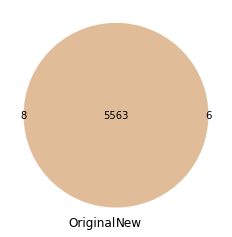

In [25]:
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
venn2([set1, set2], set_labels = ('Original', 'New'))


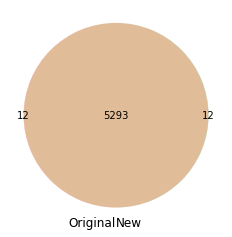

In [26]:
# Compare 24m vs 3m
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
venn2([set1, set2], set_labels = ('Original', 'New'))

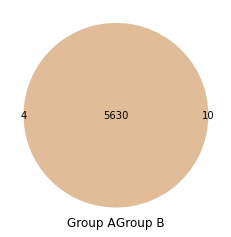

In [27]:
# Compare 24m vs 3m
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
venn2([set1, set2], set_labels = ('Group A', 'Group B'))

We see that there are very few original Mann-Whitney DEGs that are no longer significant after tie breaking, and conversely there are also very few new Mann-Whitney DEGs that were originally non-significant. This suggests that the tie-breaking procedure hardly affected the gene expression distributions between age groups.

# 3 Analysis

We examine more closely the differences between Mann-Whitney DEGs and MOCHIS DEGs. Recall that Mann-Whitney DEGs are genes that are typically picked up by standard differential analysis routines, whereas MOCHIS DEGs are genes that are differentially expressed owing to shifts in dispersion. Below, we perform some analyses to answer the following questions.

• How many MOCHIS DEGs were previously not detected by Mann-Whitney?

• Does MOCHIS really pick up shifts in dispersion?

• Are there other interesting questions we may answer with our newly detected MOCHIS DEGs?

In [28]:
## Compare counts
# Load original DEGs from Section 2.1

og_transcript_3_18 = pd.read_csv("tissues/mw_sig_3m_18m.csv")
og_transcript_18_24 = pd.read_csv("tissues/mw_sig_18m_24m.csv")
og_transcript_24_3 = pd.read_csv("tissues/mw_sig_24m_3m.csv")

# Load MOCHIS DEGs from Section 2.2
tissue_transcript_3_18 = pd.read_csv("tissues/mochis_sig_3m_18m.csv")
tissue_transcript_18_24 = pd.read_csv("tissues/mochis_sig_18m_24m.csv")
tissue_transcript_24_3 = pd.read_csv("tissues/mochis_sig_24m_3m.csv")





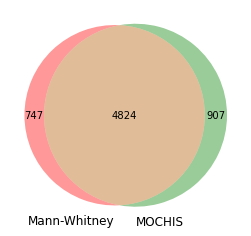

In [29]:
# Compare 3m vs 18m
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
venn2([set1, set2], set_labels = ('Mann-Whitney', 'MOCHIS'))

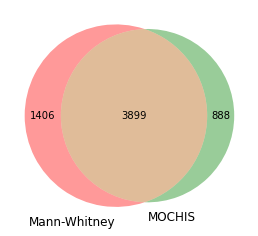

In [30]:
# Compare 18m vs 24m
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
venn2([set1, set2], set_labels = ('Mann-Whitney', 'MOCHIS'))



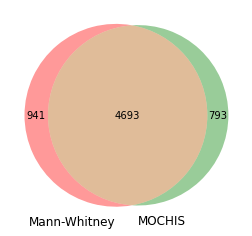

In [31]:
# Compare 3m vs 24m
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
venn2([set1, set2], set_labels = ('Mann-Whitney', 'MOCHIS'))



Summary of Findings


1. In general, there are considerable differences in the genes picked up by Mann-Whitney and MOCHIS. For any pair of age groups, MOCHIS picks up at least 750 DEGs that were not picked up by Mann-Whitney.

2. The number of new genes picked up by MOCHIS is the largest for the pair “3m vs 18m” (= 905), and smallest for the pair “3m vs 21m” (= 794).

3. The number of Mann-Whitney significant genes that are not MOCHIS significant is greatest for the pair “18m vs 24m” (= 1397) and smallest for the pair “3m vs 18m” (= 753).





## 3.2 Visualizing Changes in Dispersion

The skeptical reader may wonder if MOCHIS is really picking up a shift in dispersion between the two age groups. Since we realistically cannot compare gene expression distributions between age groups for each MOCHIS significant gene, here we show some gene expression visualizations of MOCHIS significant genes. We focus on MOCHIS DEGs that were not detected by Mann-Whitney. We show visualizations for each pair of age groups (“3m vs 18m”, “18m vs 24m” and “3m vs 24m”).

ENSMUSG00000032562 in aorta


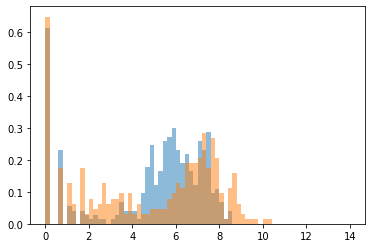

ENSMUSG00000020048 in bladder-lumen


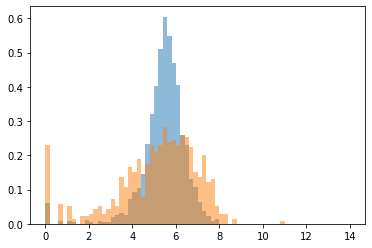

14517
ENSMUSG00000036438 in bone-marrow


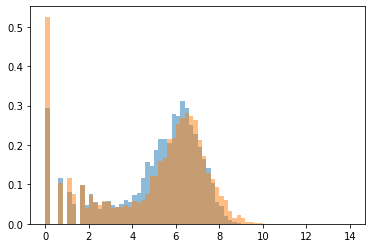

ENSMUSG00000029919 in brain-myeloid


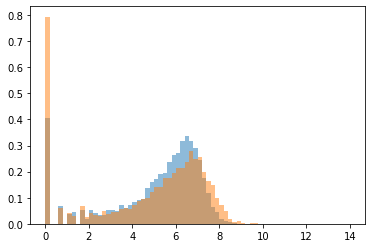

ENSMUSG00000027523 in heart


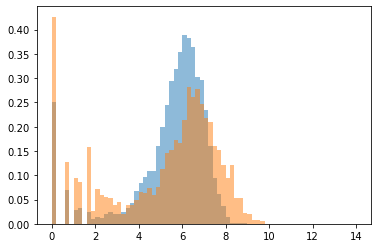

ENSMUSG00000027712 in pancreas


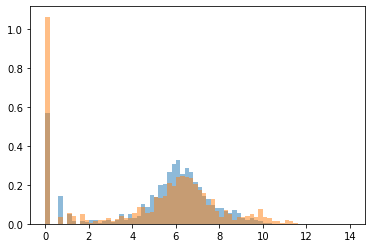

In [32]:
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_3_18.loc[(tissue_transcript_3_18['TRANSCRIPT'] == tc) & (tissue_transcript_3_18['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()
mu_aorta = mochis_unique[mochis_unique['TISSUE']=='aorta']
curated_degs_df = pd.concat([curated_degs_df, mu_aorta[mu_aorta['VARIANCE_RATIO'] == max(mu_aorta['VARIANCE_RATIO'])]])
mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])
mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])
mu_brain_myeloid = mochis_unique[mochis_unique['TISSUE']=='brain-myeloid']
curated_degs_df = pd.concat([curated_degs_df,mu_brain_myeloid[mu_brain_myeloid['VARIANCE_RATIO'] == max(mu_brain_myeloid['VARIANCE_RATIO'])]])
mu_heart = mochis_unique[mochis_unique['TISSUE']=='heart']
curated_degs_df = pd.concat([curated_degs_df,mu_heart[mu_heart['VARIANCE_RATIO'] == max(mu_heart['VARIANCE_RATIO'])]])
mu_pancreas = mochis_unique[mochis_unique['TISSUE']=='pancreas']
mu_pancreas[mu_pancreas['VARIANCE_RATIO'] == max(mu_pancreas['VARIANCE_RATIO'])]
curated_degs_df = pd.concat([curated_degs_df,mu_pancreas[mu_pancreas['VARIANCE_RATIO'] == max(mu_pancreas['VARIANCE_RATIO'])]])

# Generate plots
for i in range(len(curated_degs_df)):
    
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    if tissue == 'bone-marrow':
        print(len(smartseq2_raw_counts))
    
    
    this_gene_exp_level_3m = this_gene_exp_level[this_gene_exp_level['AGE']=='3m']
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='18m']
    
    # Visualize
    
    bins = np.arange(0, 14.2, 0.2)
    
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')



ENSMUSG00000037706 in aorta


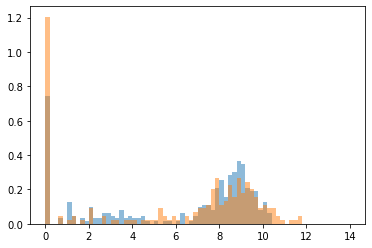

ENSMUSG00000018476 in bladder-lumen


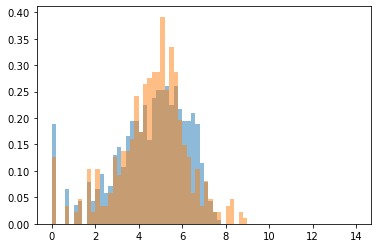

ENSMUSG00000022205 in bone-marrow


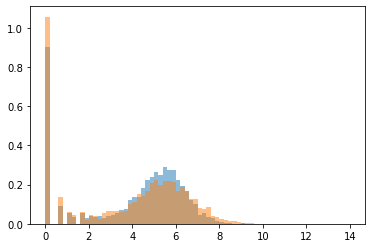

ENSMUSG00000071076 in diaphragm


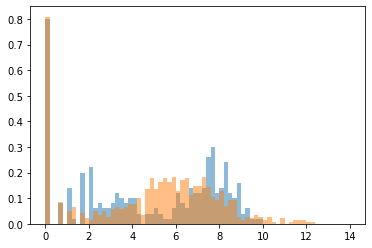

ENSMUSG00000090862 in large-intestine


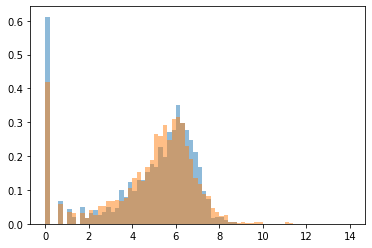

ENSMUSG00000025492 in limb-muscle


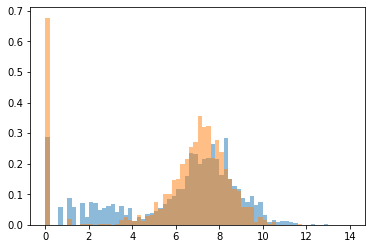

In [33]:
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_18_24.loc[(tissue_transcript_18_24['TRANSCRIPT'] == tc) & (tissue_transcript_18_24['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]
        

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()
mu_aorta = mochis_unique[mochis_unique['TISSUE']=='aorta']
curated_degs_df = pd.concat([curated_degs_df, mu_aorta[mu_aorta['VARIANCE_RATIO'] == max(mu_aorta['VARIANCE_RATIO'])]])
mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])
mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])
mu_diaphragm = mochis_unique[mochis_unique['TISSUE']=='diaphragm']
curated_degs_df = pd.concat([curated_degs_df,mu_diaphragm[mu_diaphragm['VARIANCE_RATIO'] == max(mu_diaphragm['VARIANCE_RATIO'])]])
mu_large_intestine = mochis_unique[mochis_unique['TISSUE']=='large-intestine']
curated_degs_df = pd.concat([curated_degs_df,mu_large_intestine[mu_large_intestine['VARIANCE_RATIO'] == max(mu_large_intestine['VARIANCE_RATIO'])]])
mu_limb_muscle = mochis_unique[mochis_unique['TISSUE']=='limb-muscle']
mu_limb_muscle[mu_limb_muscle['VARIANCE_RATIO'] == max(mu_limb_muscle['VARIANCE_RATIO'])]
curated_degs_df = pd.concat([curated_degs_df,mu_limb_muscle[mu_limb_muscle['VARIANCE_RATIO'] == max(mu_limb_muscle['VARIANCE_RATIO'])]])


# Generate plots
for i in range(len(curated_degs_df)):
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='18m']
    this_gene_exp_level_24m = this_gene_exp_level[this_gene_exp_level['AGE']=='24m']
    
    # Visualize
    

    bins = np.arange(0, 14.2, 0.2)
    
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')
    
    




ENSMUSG00000020745 in bladder-lumen


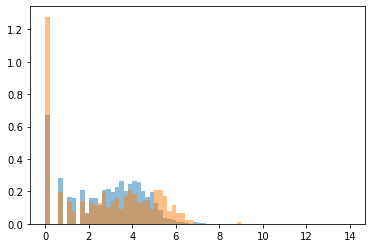

ENSMUSG00000022205 in bone-marrow


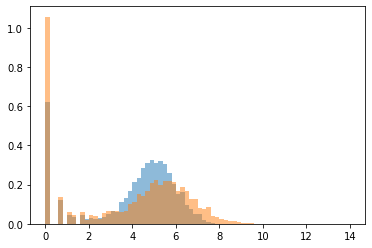

ENSMUSG00000000326 in brain-myeloid


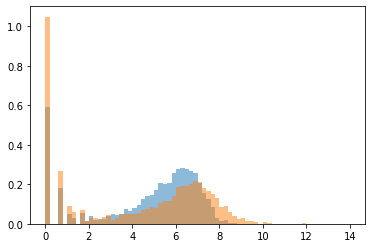

ENSMUSG00000056201 in brown-adipose-tissue


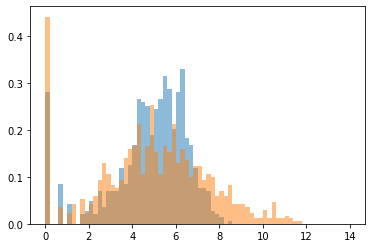

ENSMUSG00000030067 in spleen


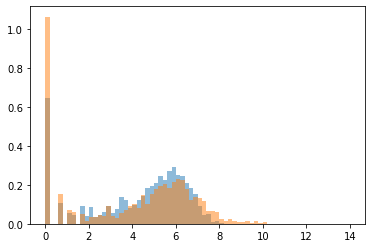

ENSMUSG00000050708 in thymus


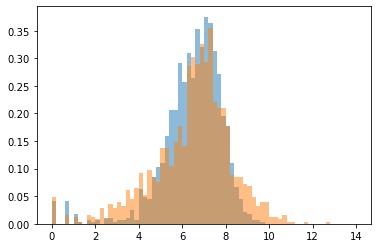

In [34]:
set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
mochis_unique = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique = pd.concat([mochis_unique, 
                                   tissue_transcript_24_3.loc[(tissue_transcript_24_3['TRANSCRIPT'] == tc) & (tissue_transcript_24_3['TISSUE'] == ts)]])
        mochis_unique.index = [i for i in range(1, len(mochis_unique)+1)]
        

# Pick genes by hand (I choose the ones with biggest variance ratio in each tissue)
curated_degs_df = pd.DataFrame()

mu_bladder_lumen = mochis_unique[mochis_unique['TISSUE']=='bladder-lumen']
curated_degs_df = pd.concat([curated_degs_df, mu_bladder_lumen[mu_bladder_lumen['VARIANCE_RATIO'] == max(mu_bladder_lumen['VARIANCE_RATIO'])]])

mu_bone_marrow = mochis_unique[mochis_unique['TISSUE']=='bone-marrow']
curated_degs_df = pd.concat([curated_degs_df, mu_bone_marrow[mu_bone_marrow['VARIANCE_RATIO'] == max(mu_bone_marrow['VARIANCE_RATIO'])]])

mu_brain_myeloid = mochis_unique[mochis_unique['TISSUE']=='brain-myeloid']
curated_degs_df = pd.concat([curated_degs_df, mu_brain_myeloid[mu_brain_myeloid['VARIANCE_RATIO'] == max(mu_brain_myeloid['VARIANCE_RATIO'])]])

mu_brown_adipose_tissue = mochis_unique[mochis_unique['TISSUE']=='brown-adipose-tissue']
curated_degs_df = pd.concat([curated_degs_df,mu_brown_adipose_tissue[mu_brown_adipose_tissue['VARIANCE_RATIO'] == max(mu_brown_adipose_tissue['VARIANCE_RATIO'])]])

mu_spleen = mochis_unique[mochis_unique['TISSUE']=='spleen']
curated_degs_df = pd.concat([curated_degs_df,mu_spleen[mu_spleen['VARIANCE_RATIO'] == max(mu_spleen['VARIANCE_RATIO'])]])
mu_thymus = mochis_unique[mochis_unique['TISSUE']=='thymus']
curated_degs_df = pd.concat([curated_degs_df,mu_thymus[mu_thymus['VARIANCE_RATIO'] == max(mu_thymus['VARIANCE_RATIO'])]])


# Generate plots
for i in range(len(curated_degs_df)):
    tissue = curated_degs_df.iloc[i]['TISSUE']
    transcript = curated_degs_df.iloc[i]['TRANSCRIPT']
    
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    
    this_gene_exp_level_3m = this_gene_exp_level[this_gene_exp_level['AGE']=='3m']
    this_gene_exp_level_24m = this_gene_exp_level[this_gene_exp_level['AGE']=='24m']
    
    # Visualize
    

    bins = np.arange(0, 14.2, 0.2)
    
    
    print(transcript + " in " + tissue)
    plt.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    plt.show()
    
    
    #plt.legend(loc='upper right')
    
    




#### Summary of Findings

We find that

1. MOCHIS detects shifts in dispersions. These shifts can be in either direction (positive or negative). 

2. Some of the shifts can be attributed to more pronounced zero inflation in one age group than another (based on post-analysis visualizations). This raises an important caveat in our analysis, namely, that our first step of filtering out genes that have more than 20% zero-inflation rate effectively removes all contribution by technical noise to the data. If we are skeptical, then we must find other ways to effectively remove contribution by technical noise.


## 3.3 Other Interesting Results

We show how we can further interpret our results to answer biologically meaningful questions.
Gene Up-regulation vs Down-regulation. We have only looked at changes in dispersion, without explicitly tracking the directionality of change. We report, for each tissue and the corresponding pair of age groups, the fraction of positive and negative changes in dispersion, as measured by the ratio of variances.

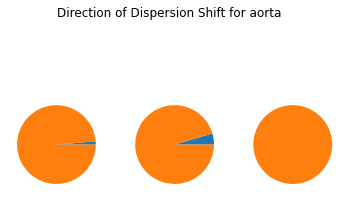

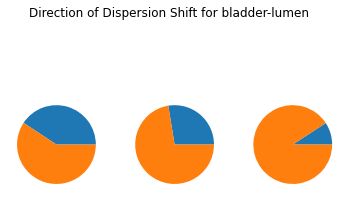

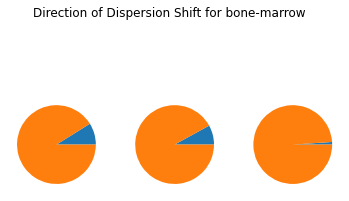

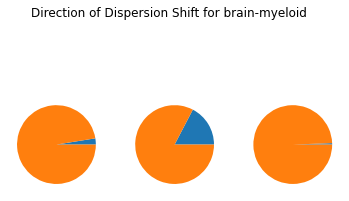

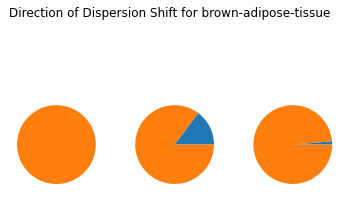

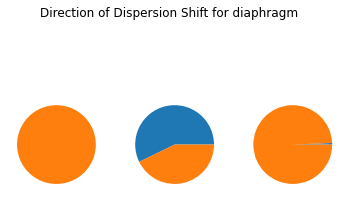

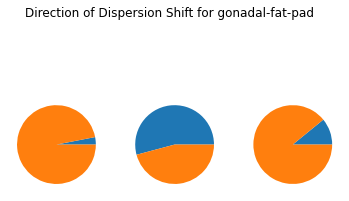

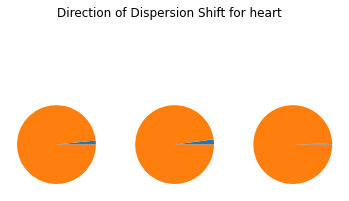

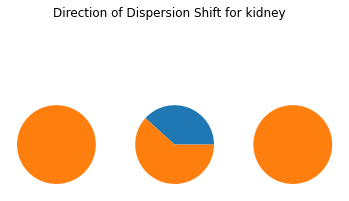

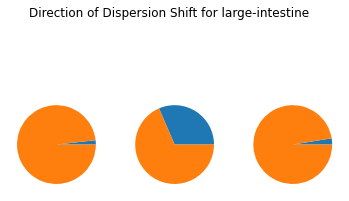

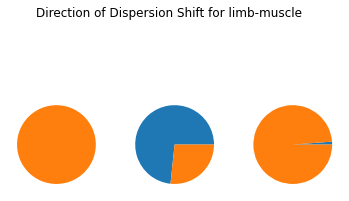

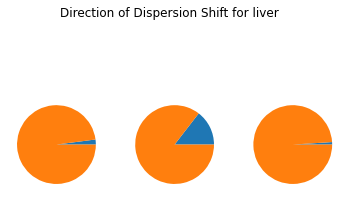

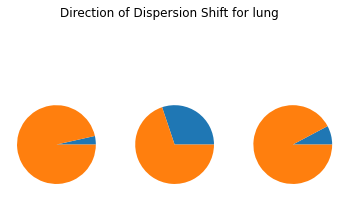

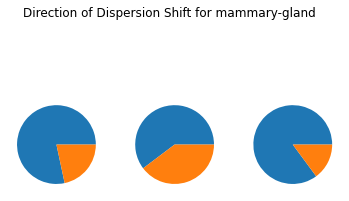

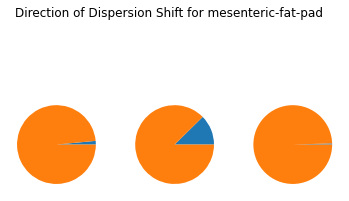

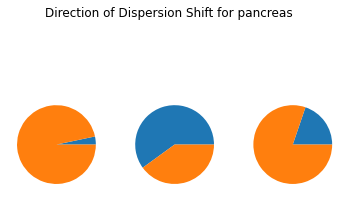

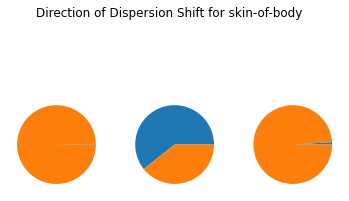

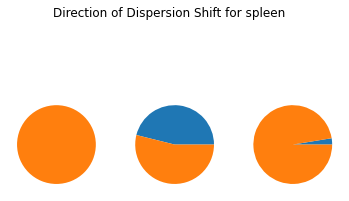

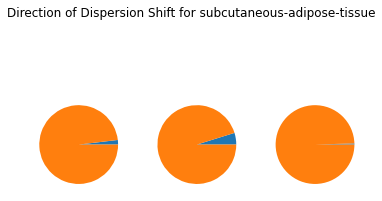

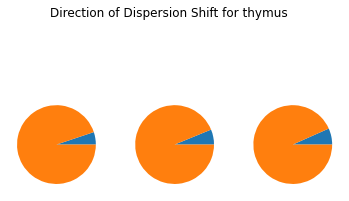

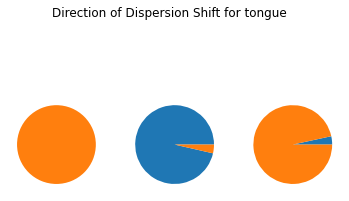

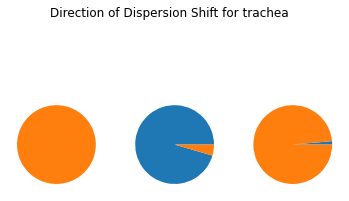

In [35]:
## Report tissue-specific distribution of up-regulated
## and down-regulated genes between age groups
# Define all_tissues again

mochis_degs_3_18 = pd.read_csv("tissues/mochis_sig_3m_18m.csv")
mochis_degs_18_24 = pd.read_csv("tissues/mochis_sig_18m_24m.csv")
mochis_degs_3_24 = pd.read_csv("tissues/mochis_sig_24m_3m.csv")

up_down_reg_df = pd.DataFrame(columns = ['TISSUE', 
                                         'DOWN_3_18', 
                                         'UP_3_18', 
                                         'DOWN_18_24',
                                         'UP_18_24',
                                         'DOWN_3_24',
                                         'UP_3_24'])

for tissue in all_tissues:
    
    results_df = pd.read_csv("tissues/" + tissue + "/mochis_p_val_table.csv")
    
    # Analysis for 3m vs 18m
    # mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT
    mochis_degs_3_18_by_tissue = mochis_degs_3_18[mochis_degs_3_18['TISSUE'] == tissue]['TRANSCRIPT']
    # subset(TRANSCRIPT %in% (mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT)
    results_df_by_tissue = results_df[results_df['TRANSCRIPT'].isin(mochis_degs_3_18_by_tissue)]
    results_df_INV_3_18 = results_df_by_tissue['INV_3_18']
    n_3_18_down = sum(results_df_INV_3_18)
    n_3_18_up = len(results_df_by_tissue) - n_3_18_down
    
    
    
    # Analysis for 18m vs 24m
    # mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT
    mochis_degs_18_24_by_tissue = mochis_degs_18_24[mochis_degs_18_24['TISSUE'] == tissue]['TRANSCRIPT']
    # subset(TRANSCRIPT %in% (mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT)
    results_df_by_tissue = results_df[results_df['TRANSCRIPT'].isin(mochis_degs_18_24_by_tissue)]
    results_df_INV_18_24 = results_df_by_tissue['INV_18_24']
    n_18_24_down = sum(results_df_INV_18_24)
    n_18_24_up = len(results_df_by_tissue) - n_18_24_down

    
    # Analysis for 3m vs 18m
    # mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT
    mochis_degs_3_24_by_tissue = mochis_degs_3_24[mochis_degs_3_24['TISSUE'] == tissue]['TRANSCRIPT']
    # subset(TRANSCRIPT %in% (mochis_degs_3_18 %>% subset(TISSUE == tissue))$TRANSCRIPT)
    results_df_by_tissue = results_df[results_df['TRANSCRIPT'].isin(mochis_degs_3_24_by_tissue)]
    results_df_INV_3_24 = results_df_by_tissue['INV_24_3']
    n_3_24_down = sum(results_df_INV_3_24)
    n_3_24_up = len(results_df_by_tissue) - n_3_24_down
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    fig.suptitle('Direction of Dispersion Shift for ' + tissue)
    ax1.pie([n_3_18_down,n_3_18_up])
    ax2.pie([n_18_24_down,n_18_24_up])
    ax3.pie([n_3_24_down,n_3_24_up])
    plt.show()
    
    
    up_down_reg_df = pd.concat([up_down_reg_df, pd.DataFrame([{
        'TISSUE': tissue,
        'DOWN_3_18': n_3_18_down,
        'UP_3_18': n_3_18_up,
        'DOWN_18_24': n_18_24_down,
        'UP_18_24': n_18_24_up,
        'DOWN_3_24': n_3_24_down,
        'UP_3_24': n_3_24_up
    }])])
    #print(s)
    



    


In [36]:
print("The following tissues tend to exhibit increased gene regulation from 3m to 18m:")
up_down_reg_df[up_down_reg_df['UP_3_18']/(up_down_reg_df['UP_3_18'] + up_down_reg_df['DOWN_3_18']) > 0.5]['TISSUE']




The following tissues tend to exhibit increased gene regulation from 3m to 18m:


0                          aorta
0                  bladder-lumen
0                    bone-marrow
0                  brain-myeloid
0           brown-adipose-tissue
0                      diaphragm
0                gonadal-fat-pad
0                          heart
0                         kidney
0                large-intestine
0                    limb-muscle
0                          liver
0                           lung
0             mesenteric-fat-pad
0                       pancreas
0                   skin-of-body
0                         spleen
0    subcutaneous-adipose-tissue
0                         thymus
0                         tongue
0                        trachea
Name: TISSUE, dtype: object

In [37]:
print("The following tissues tend to exhibit increased gene regulation from 18m to 24m:")
up_down_reg_df[up_down_reg_df['UP_18_24']/(up_down_reg_df['UP_18_24'] + up_down_reg_df['DOWN_18_24']) > 0.5]['TISSUE']




The following tissues tend to exhibit increased gene regulation from 18m to 24m:


0                          aorta
0                  bladder-lumen
0                    bone-marrow
0                  brain-myeloid
0           brown-adipose-tissue
0                          heart
0                         kidney
0                large-intestine
0                          liver
0                           lung
0             mesenteric-fat-pad
0                         spleen
0    subcutaneous-adipose-tissue
0                         thymus
Name: TISSUE, dtype: object

In [38]:
print("The following tissues tend to exhibit increased gene regulation from 3m to 24m:")
up_down_reg_df[up_down_reg_df['UP_3_24']/(up_down_reg_df['UP_3_24'] + up_down_reg_df['DOWN_3_24']) > 0.5]['TISSUE']




The following tissues tend to exhibit increased gene regulation from 3m to 24m:


0                          aorta
0                  bladder-lumen
0                    bone-marrow
0                  brain-myeloid
0           brown-adipose-tissue
0                      diaphragm
0                gonadal-fat-pad
0                          heart
0                         kidney
0                large-intestine
0                    limb-muscle
0                          liver
0                           lung
0             mesenteric-fat-pad
0                       pancreas
0                   skin-of-body
0                         spleen
0    subcutaneous-adipose-tissue
0                         thymus
0                         tongue
0                        trachea
Name: TISSUE, dtype: object

Persistently Differentially Expressed Genes. It is possible that for some tissues, gene regulation is so dynamic over the lifecourse, manifesting in detectable gene expression changes across time. To this end, we consider DEGs that are persistently differentiated; these are genes that are differentially expressed among all pairs of age groups. For brevity, we shall refer to them as persistently DEGs.
First, we ask how many such persistently DEGs there are.

In [39]:
## Identify persistently differentially expressed genes
# Find all unique tissue-transcript pairs in results
tissue_transcript_combined = pd.concat([
    tissue_transcript_3_18[['TISSUE', 'TRANSCRIPT']],
    tissue_transcript_18_24[['TISSUE', 'TRANSCRIPT']],
    tissue_transcript_24_3[['TISSUE', 'TRANSCRIPT']]
]).drop_duplicates()

# Compute the persistent DEGs
age3m_vs_age18m = []
age18m_vs_age24m = []
age3m_vs_age24m = []

for i in range(len(tissue_transcript_combined)):
    tissue_transcript_24_3_subset = tissue_transcript_24_3[(tissue_transcript_24_3['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_24_3['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(tissue_transcript_24_3_subset)) > 0:
        age3m_vs_age24m.append(1)
    else:
        age3m_vs_age24m.append(0)
    
    tissue_transcript_3_18_subset = tissue_transcript_3_18[(tissue_transcript_3_18['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_3_18['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(tissue_transcript_3_18_subset)) > 0:
        age3m_vs_age18m.append(1)
    else:
        age3m_vs_age18m.append(0)
    
    tissue_transcript_18_24_subset = tissue_transcript_18_24[(tissue_transcript_18_24['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_18_24['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(tissue_transcript_18_24_subset)) > 0:
        age18m_vs_age24m.append(1)
    else:
        age18m_vs_age24m.append(0)

        
tissue_transcript_combined['AGE3M_VS_AGE18M'] = age3m_vs_age18m
tissue_transcript_combined['AGE18M_VS_AGE24M'] = age18m_vs_age24m
tissue_transcript_combined['AGE3M_VS_AGE24M'] = age3m_vs_age24m
tissue_transcript_combined['PERSISTENCE'] = np.add(np.add(age3m_vs_age18m, age18m_vs_age24m), age3m_vs_age24m)

# How many persistently DEGs are there?
print("There are ",
             np.count_nonzero(tissue_transcript_combined['PERSISTENCE']==3),
             " persistently DEGs.")
                                             
                             

There are  3576  persistently DEGs.


In [40]:
# Look closely at persistent DEGs
curated_persistent_degs = tissue_transcript_combined[tissue_transcript_combined['PERSISTENCE']==3]
curated_persistent_degs






,TISSUE,TRANSCRIPT,AGE3M_VS_AGE18M,AGE18M_VS_AGE24M,AGE3M_VS_AGE24M,PERSISTENCE
1,aorta,ENSMUSG00000090862,1,1,1,3
3,aorta,ENSMUSG00000060743,1,1,1,3
18,aorta,ENSMUSG00000004207,1,1,1,3
31,aorta,ENSMUSG00000032399,1,1,1,3
33,aorta,ENSMUSG00000037706,1,1,1,3
...,...,...,...,...,...,...
5725,trachea,ENSMUSG00000015656,1,1,1,3
5727,trachea,ENSMUSG00000023010,1,1,1,3
5728,trachea,ENSMUSG00000092341,1,1,1,3
5729,trachea,ENSMUSG00000060636,1,1,1,3


To underscore the utility of our method at picking up DEGs that would otherwise be overlooked, we look at persistently DEGs (if there are any!) that would not be picked up by Mann-Whitney.

In [41]:
## Find and visualize some persistently DEGs
## that are not Mann-Whitney significant
# Identify those in MOCHIS but not Mann-Whitney
set1 = set(og_transcript_3_18['TRANSCRIPT'] + "_" + og_transcript_3_18['TISSUE'])
set2 = set(tissue_transcript_3_18['TRANSCRIPT'] + "_" + tissue_transcript_3_18['TISSUE'])
mochis_unique_3_18 = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique_3_18 = pd.concat([mochis_unique_3_18, 
                                   tissue_transcript_3_18.loc[(tissue_transcript_3_18['TRANSCRIPT'] == tc) & (tissue_transcript_3_18['TISSUE'] == ts)]])


        
set1 = set(og_transcript_18_24['TRANSCRIPT'] + "_" + og_transcript_18_24['TISSUE'])
set2 = set(tissue_transcript_18_24['TRANSCRIPT'] + "_" + tissue_transcript_18_24['TISSUE'])
mochis_unique_18_24 = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique_18_24 = pd.concat([mochis_unique_18_24, 
                                   tissue_transcript_18_24.loc[(tissue_transcript_18_24['TRANSCRIPT'] == tc) & (tissue_transcript_18_24['TISSUE'] == ts)]])


set1 = set(og_transcript_24_3['TRANSCRIPT'] + "_" + og_transcript_24_3['TISSUE'])
set2 = set(tissue_transcript_24_3['TRANSCRIPT'] + "_" + tissue_transcript_24_3['TISSUE'])
mochis_unique_24_3 = pd.DataFrame()
for elem in set2:
    if elem not in set1:
        tc = elem.split("_")[0]
        ts = elem.split("_")[1]
        mochis_unique_24_3 = pd.concat([mochis_unique_24_3, 
                                   tissue_transcript_24_3.loc[(tissue_transcript_24_3['TRANSCRIPT'] == tc) & (tissue_transcript_24_3['TISSUE'] == ts)]])


        
        
        
        
## Identify persistently differentially expressed genes
# Find all unique tissue-transcript pairs in results
tissue_transcript_combined = pd.concat([
    mochis_unique_3_18[['TISSUE', 'TRANSCRIPT']],
    mochis_unique_18_24[['TISSUE', 'TRANSCRIPT']],
    mochis_unique_24_3[['TISSUE', 'TRANSCRIPT']]
]).drop_duplicates()

# Compute the persistent DEGs
age3m_vs_age18m = []
age18m_vs_age24m = []
age3m_vs_age24m = []

for i in range(len(tissue_transcript_combined)):
    mochis_unique_24_3_subset = mochis_unique_24_3[(tissue_transcript_24_3['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_24_3['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(mochis_unique_24_3_subset)) > 0:
        age3m_vs_age24m.append(1)
    else:
        age3m_vs_age24m.append(0)
    
    mochis_unique_3_18_subset = mochis_unique_3_18[(tissue_transcript_3_18['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_3_18['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(mochis_unique_3_18_subset)) > 0:
        age3m_vs_age18m.append(1)
    else:
        age3m_vs_age18m.append(0)
    
    mochis_unique_18_24_subset = mochis_unique_18_24[(tissue_transcript_18_24['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) & 
                                                          (tissue_transcript_18_24['TRANSCRIPT']==tissue_transcript_combined.iloc[i]['TRANSCRIPT'])]
    if (len(mochis_unique_18_24_subset)) > 0:
        age18m_vs_age24m.append(1)
    else:
        age18m_vs_age24m.append(0)

        
tissue_transcript_combined['AGE3M_VS_AGE18M'] = age3m_vs_age18m
tissue_transcript_combined['AGE18M_VS_AGE24M'] = age18m_vs_age24m
tissue_transcript_combined['AGE3M_VS_AGE24M'] = age3m_vs_age24m
tissue_transcript_combined['PERSISTENCE'] = np.add(np.add(age3m_vs_age18m, age18m_vs_age24m), age3m_vs_age24m)

# How many persistently DEGs are there?
print("There are ",
             np.count_nonzero(tissue_transcript_combined['PERSISTENCE']==3),
             " persistently DEGs not previously detected by Mann-Whitney.")
                                             
                             



<ipython-input-41-8a77d8d7523f>:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mochis_unique_24_3_subset = mochis_unique_24_3[(tissue_transcript_24_3['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) &
<ipython-input-41-8a77d8d7523f>:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mochis_unique_3_18_subset = mochis_unique_3_18[(tissue_transcript_3_18['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) &
<ipython-input-41-8a77d8d7523f>:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mochis_unique_18_24_subset = mochis_unique_18_24[(tissue_transcript_18_24['TISSUE']==tissue_transcript_combined.iloc[i]['TISSUE']) &


There are  69  persistently DEGs not previously detected by Mann-Whitney.


In [42]:
# Look closely at persistent DEGs
curated_persistent_degs = tissue_transcript_combined[tissue_transcript_combined['PERSISTENCE']==3]
curated_persistent_degs






,TISSUE,TRANSCRIPT,AGE3M_VS_AGE18M,AGE18M_VS_AGE24M,AGE3M_VS_AGE24M,PERSISTENCE
3871,skin-of-body,ENSMUSG00000018583,1,1,1,3
1468,diaphragm,ENSMUSG00000018593,1,1,1,3
2559,limb-muscle,ENSMUSG00000058558,1,1,1,3
1893,heart,ENSMUSG00000021025,1,1,1,3
4538,thymus,ENSMUSG00000006699,1,1,1,3
...,...,...,...,...,...,...
2935,mammary-gland,ENSMUSG00000056537,1,1,1,3
5484,tongue,ENSMUSG00000010608,1,1,1,3
112,bladder-lumen,ENSMUSG00000041959,1,1,1,3
5519,trachea,ENSMUSG00000060743,1,1,1,3


From the chunk above, we find that 66 tissue-specific genes are persistently DEGs. Moreover, most of them come from the bladder lumen and the heart. Let us visualize some of these genes.

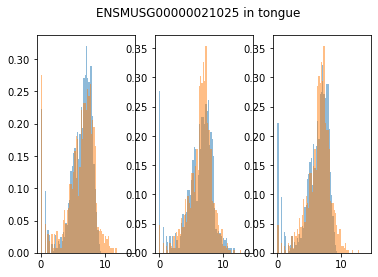

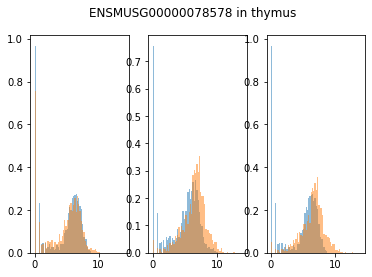

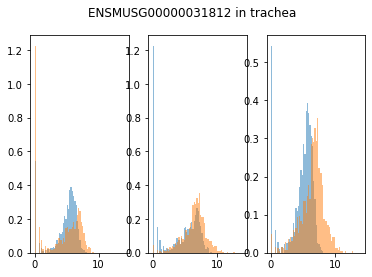

In [47]:
## Visualizing MOCHIS-exclusive persistently DEGs
# Generate plots of gene expressions for persistent DEGs
plot_list = []

for i in [7,17,29]:
    
    # Get raw read counts data for that tissue and transcript
    tissue = curated_persistent_degs.iloc[i]['TISSUE']
    transcript = curated_persistent_degs.iloc[i]['TRANSCRIPT']
    
    # Create local list
    this_deg_plot_list = []
    # Open tissue-specific data and select gene
    tissue_smartseq2_data = scanpy.read_h5ad('tissues/' + tissue + '.h5ad')
    transcripts = tissue_smartseq2_data.var.n_cells.index
    ages = np.array(tissue_smartseq2_data.obs['age'].values)
    smartseq2_raw_counts = tissue_smartseq2_data.raw.X.toarray()
   
    this_gene_exp_level = pd.DataFrame({
        'TRANSCRIPT': smartseq2_raw_counts[:, np.where(transcripts==transcript)[0][0]],
        'AGE': ages
    })
    
    
    this_gene_exp_level_3m = this_gene_exp_level[this_gene_exp_level['AGE']=='3m']
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='18m']
    this_gene_exp_level_18m = this_gene_exp_level[this_gene_exp_level['AGE']=='24m']
    
    # Visualize
    
    
    
    bins = np.arange(0, 14.2, 0.2)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    fig.suptitle(transcript + " in " + tissue)
    ax1.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    ax1.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    
    ax2.hist([math.log(i+1) for i in this_gene_exp_level_18m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    ax2.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    
    ax3.hist([math.log(i+1) for i in this_gene_exp_level_3m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    ax3.hist([math.log(i+1) for i in this_gene_exp_level_24m['TRANSCRIPT'].values], bins=bins, density=True, alpha=0.5, label='x')
    
    plt.show()
    
    

In [44]:
## Generate dataframe summarizing direction of dispersion changes
persistent_degs_direction_df = pd.DataFrame(columns=['TISSUE', 'TRANSCRIPT', 'AGE3M_VS_AGE18M', 'AGE18M_VS_AGE24M', 'AGE3M_VS_AGE24M'])

for i in range(len(curated_persistent_degs)):
    tissue = curated_persistent_degs.iloc[i]['TISSUE']
    transcript = curated_persistent_degs.iloc[i]['TRANSCRIPT']
    
    results_df = pd.read_csv("tissues/" + tissue + "/mochis_p_val_table.csv")
    
    relevant_row = results_df[results_df['TRANSCRIPT']==transcript]
    
    
    inv_3_18 = '+'
    inv_18_24 = '+'
    inv_3_24 = '+'
    if relevant_row['INV_3_18'].values[0]:
        inv_3_18 = "-"
    if relevant_row['INV_18_24'].values[0]:
        inv_18_24 = "-"
    if relevant_row['INV_24_3'].values[0]:
        inv_3_24 = "-"
        
    
    persistent_degs_direction_df = pd.concat([persistent_degs_direction_df, pd.DataFrame([{
        'TISSUE': tissue,
        'TRANSCRIPT': transcript,
        'AGE3M_VS_AGE18M': inv_3_18,
        'AGE18M_VS_AGE24M': inv_18_24,
        'AGE3M_VS_AGE24M': inv_3_24
    }])]).sort_values('TISSUE')


    

In [45]:
persistent_degs_direction_df

,TISSUE,TRANSCRIPT,AGE3M_VS_AGE18M,AGE18M_VS_AGE24M,AGE3M_VS_AGE24M
0,bladder-lumen,ENSMUSG00000030824,+,-,+
0,bladder-lumen,ENSMUSG00000028757,+,-,+
0,bladder-lumen,ENSMUSG00000006498,+,-,+
0,bladder-lumen,ENSMUSG00000021877,+,-,+
0,bladder-lumen,ENSMUSG00000037373,+,-,+
...,...,...,...,...,...
0,trachea,ENSMUSG00000026234,+,-,+
0,trachea,ENSMUSG00000055302,+,-,+
0,trachea,ENSMUSG00000028367,+,-,+
0,trachea,ENSMUSG00000024190,+,-,+
